In [1]:
import torch
torch.cuda.empty_cache()
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# XAI tools
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import timm

for input download input from https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

In [2]:
import pandas as pd

# path to the CSV file with metadata about the images
META_PATH = 'HAM10000_metadata.csv'
df = pd.read_csv(META_PATH)
print("Metadata loaded. Shape:", df.shape)
df.head()


Metadata loaded. Shape: (10015, 7)


lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [3]:
# list image files in both folders after unzip
IMG_DIR1 = 'DV/HAM10000_images_part_1'
IMG_DIR2 = 'DV/HAM10000_images_part_2'
image_files_1 = set(os.listdir(IMG_DIR1))
image_files_2 = set(os.listdir(IMG_DIR2))
#combine all images into one set
all_image_files = image_files_1.union(image_files_2)

# Check for missing images
missing_images = []
for img_id in df['image_id']:
    fname = img_id + '.jpg'
    if fname not in all_image_files:
        missing_images.append(fname)

if not missing_images:
    print("All images referenced in metadata are present in the folders.")
else:
    print(f"Missing images: {len(missing_images)}")
    print(missing_images[:10])  # missing images 


All images referenced in metadata are present in the folders.


Unique diagnosis codes: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


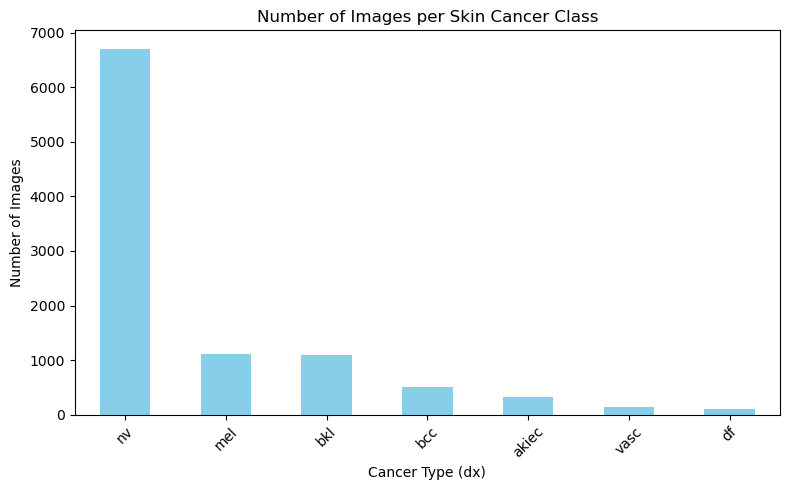

In [4]:
import matplotlib.pyplot as plt

# check the column with diagnostic labels (dx)
print("Unique diagnosis codes:", df['dx'].unique())

# count per class
class_counts = df['dx'].value_counts()
print(class_counts)

# Plot as a bar chart
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Images per Skin Cancer Class")
plt.xlabel("Cancer Type (dx)")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

SEED = 42 #random seed  

# Split based on lesions(skin spot)
split_col = 'lesion_id'
#unique lesion ids
unique_lesions = df[split_col].unique()
#split (85% train, 15% test)
train_lesions, test_lesions = train_test_split(unique_lesions, test_size=0.15, random_state=SEED)
df['split'] = df[split_col].apply(lambda x: 'test' if x in test_lesions else 'train')
#split training lesions into training and validation sets (15% validation)
train_lesions_only = df[df['split'] == 'train'][split_col].unique()
train_lesions, val_lesions = train_test_split(train_lesions_only, test_size=0.15, random_state=SEED)
df.loc[df[split_col].isin(val_lesions), 'split'] = 'val'
print(df['split'].value_counts())
print(df.groupby(['split', 'dx']).size().unstack(fill_value=0))


split
train    7233
test     1543
val      1239
Name: count, dtype: int64
dx     akiec  bcc  bkl  df  mel    nv  vasc
split                                      
test      52   94  180  29  176   983    29
train    247  368  754  75  814  4886    89
val       28   52  165  11  123   836    24


In [6]:
from sklearn.preprocessing import LabelEncoder
#label encoder object to turn text labels into numbers
le = LabelEncoder()
#convert the 'dx' column (diagnosis names) into numbers and store in 'label_idx'
df['label_idx'] = le.fit_transform(df['dx'])
class_names = le.classes_
num_classes = len(class_names)
print("Classes:", list(class_names))


Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [7]:
#custom Dataset class for skin lesion images
class SkinLesionDataset(Dataset):
    def __init__(self, df, img_dir1, img_dir2, split='train', transform=None):
        #filter the dataframe for the chosen split (train/val/test)
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.img_dir1 = img_dir1
        self.img_dir2 = img_dir2
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_filename = row['image_id'] + '.jpg'
        img_path = os.path.join(self.img_dir1, img_filename)
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir2, img_filename)
        #convert image to RGB
        image = Image.open(img_path).convert('RGB')
        label = row['label_idx']
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
#transformations for validation/testing (just resize and normalize)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Datasets
train_dataset = SkinLesionDataset(df, IMG_DIR1, IMG_DIR2, split='train', transform=train_transform)
val_dataset   = SkinLesionDataset(df, IMG_DIR1, IMG_DIR2, split='val', transform=test_transform)
test_dataset  = SkinLesionDataset(df, IMG_DIR1, IMG_DIR2, split='test', transform=test_transform)

# DataLoaders for easy batch loading
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [8]:
#single batch from the train_loader
images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)
print("First 5 labels:", labels[:5])


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
First 5 labels: tensor([4, 0, 5, 5, 5])


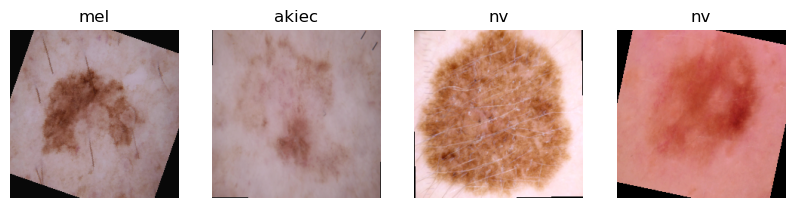

In [9]:
import matplotlib.pyplot as plt
#image tensor as a normal image
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))#rearrange dimensions to (H, W, C)
    img = img * 0.5 + 0.5  # unnormalize from [-1,1] to [0,1]
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

plt.figure(figsize=(10,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    imshow(images[i], class_names[labels[i]])
plt.show()


In [10]:
print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))
print("Test batches:", len(test_loader))


Train batches: 227
Validation batches: 39
Test batches: 49


In [11]:
import timm
import torch
import torch.nn as nn
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 7  # Set to your number of classes
#model setup
model_configs = {
    "resnet18": {
        "type": "cnn",
        "init_fn": lambda: models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    },
    "resnet34": {
        "type": "cnn",
        "init_fn": lambda: models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    },
    "efficientnet_b0": {
        "type": "cnn",
        "init_fn": lambda: timm.create_model("efficientnet_b0", pretrained=True)
    },
    "vit_tiny_patch16_224": {
        "type": "vit",
        "init_fn": lambda: timm.create_model("vit_tiny_patch16_224", pretrained=True)
    },
    "vit_small_patch16_224": {   
        "type": "vit",
        "init_fn": lambda: timm.create_model("vit_small_patch16_224", pretrained=True)
    },
    "swin_tiny_patch4_window7_224": {
        "type": "swin",
        "init_fn": lambda: timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, global_pool="avg")
    }
}
#loop over each model, create it, and set its final classifier layer for number of classes
for m in model_configs:
    model = model_configs[m]["init_fn"]()#create the model (pretrained)
    #for CNNs, set the final fully connected/classifier layer
    if model_configs[m]["type"] == "cnn":
        if hasattr(model, "fc"):
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif hasattr(model, "classifier"):
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, num_classes)
    else:  # for all ViTs/Swin
        model.head = nn.Linear(model.head.in_features, num_classes)
    model_configs[m]["model"] = model.to(device)


In [12]:
def train_model(model, train_loader, val_loader, num_epochs=5, lr=1e-4):
    #set up Adam optimizer and cross-entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0.0 #best validation accuracy
    best_model_wts = None #weights of the best model

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        #training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # flattening
            if outputs.ndim > 2:
                outputs = outputs.mean(dim=[2,3])  # Average pool [B, C, H, W] → [B, C]
            
            loss = criterion(outputs, labels)
            loss.backward() #backpropagate loss
            optimizer.step() #update weights
            _, preds = torch.max(outputs, 1) #get predicted class indices
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
        #average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if outputs.ndim > 2:
                    outputs = outputs.mean(dim=[2,3])
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {epoch_loss:.4f}, Train Acc {epoch_acc:.4f}, Val Acc {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()

    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    print(f"Best Val Acc: {best_val_acc:.4f}")
    return model

#traing all models
trained_models = {}
for model_name, cfg in model_configs.items():
    print(f"\nTraining {model_name.upper()}")
    model = cfg["model"]
    trained_model = train_model(model, train_loader, val_loader, num_epochs=5, lr=1e-4)
    trained_models[model_name] = trained_model



Training RESNET18
Epoch 1/5: Train Loss 0.7580, Train Acc 0.7410, Val Acc 0.8063
Epoch 2/5: Train Loss 0.4808, Train Acc 0.8236, Val Acc 0.8160
Epoch 3/5: Train Loss 0.3925, Train Acc 0.8569, Val Acc 0.8144
Epoch 4/5: Train Loss 0.3250, Train Acc 0.8792, Val Acc 0.8224
Epoch 5/5: Train Loss 0.2880, Train Acc 0.8926, Val Acc 0.7902
Best Val Acc: 0.8224

Training RESNET34
Epoch 1/5: Train Loss 0.7443, Train Acc 0.7471, Val Acc 0.7950
Epoch 2/5: Train Loss 0.4820, Train Acc 0.8261, Val Acc 0.7893
Epoch 3/5: Train Loss 0.3939, Train Acc 0.8623, Val Acc 0.8095
Epoch 4/5: Train Loss 0.3382, Train Acc 0.8782, Val Acc 0.8273
Epoch 5/5: Train Loss 0.2927, Train Acc 0.8929, Val Acc 0.8208
Best Val Acc: 0.8273

Training EFFICIENTNET_B0
Epoch 1/5: Train Loss 0.8214, Train Acc 0.7261, Val Acc 0.8047
Epoch 2/5: Train Loss 0.4803, Train Acc 0.8233, Val Acc 0.8184
Epoch 3/5: Train Loss 0.3524, Train Acc 0.8757, Val Acc 0.8160
Epoch 4/5: Train Loss 0.2710, Train Acc 0.9060, Val Acc 0.8273
Epoch 5/5: T


RESNET18 Evaluation:
all_labels (unique): [0 1 2 3 4 5 6]
all_preds (unique): [0 1 2 3 4 5 6]
              precision    recall  f1-score   support

       akiec       0.47      0.27      0.34        52
         bcc       0.54      0.73      0.62        94
         bkl       0.54      0.79      0.64       180
          df       0.82      0.31      0.45        29
         mel       0.58      0.60      0.59       176
          nv       0.93      0.85      0.89       983
        vasc       0.82      0.79      0.81        29

    accuracy                           0.78      1543
   macro avg       0.67      0.62      0.62      1543
weighted avg       0.80      0.78      0.78      1543



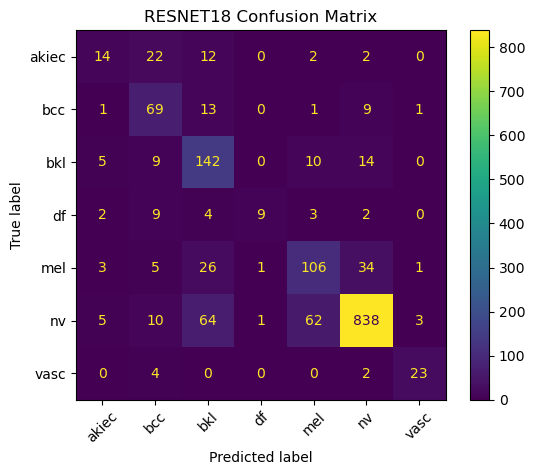


RESNET34 Evaluation:
all_labels (unique): [0 1 2 3 4 5 6]
all_preds (unique): [0 1 2 3 4 5 6]
              precision    recall  f1-score   support

       akiec       0.59      0.25      0.35        52
         bcc       0.67      0.52      0.59        94
         bkl       0.78      0.52      0.62       180
          df       0.93      0.45      0.60        29
         mel       0.44      0.55      0.48       176
          nv       0.88      0.94      0.91       983
        vasc       0.66      0.86      0.75        29

    accuracy                           0.79      1543
   macro avg       0.71      0.58      0.61      1543
weighted avg       0.79      0.79      0.78      1543



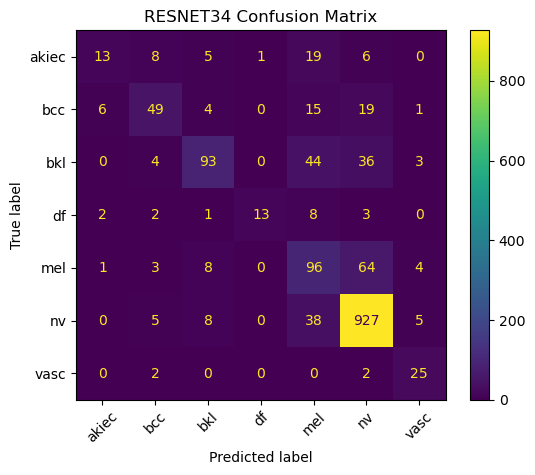


EFFICIENTNET_B0 Evaluation:
all_labels (unique): [0 1 2 3 4 5 6]
all_preds (unique): [0 1 2 3 4 5 6]
              precision    recall  f1-score   support

       akiec       0.55      0.50      0.53        52
         bcc       0.79      0.69      0.74        94
         bkl       0.69      0.72      0.70       180
          df       1.00      0.10      0.19        29
         mel       0.60      0.54      0.57       176
          nv       0.89      0.94      0.91       983
        vasc       0.96      0.93      0.95        29

    accuracy                           0.82      1543
   macro avg       0.78      0.63      0.66      1543
weighted avg       0.82      0.82      0.81      1543



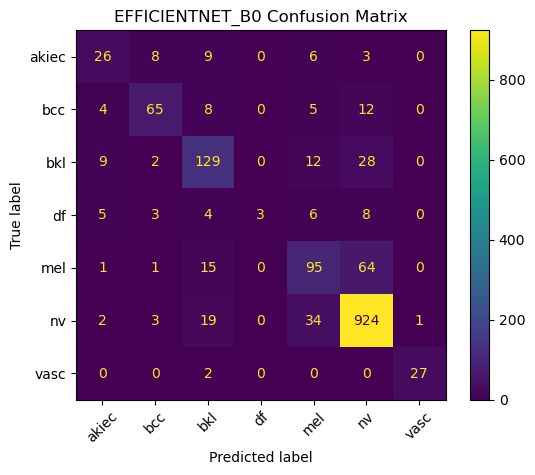


VIT_TINY_PATCH16_224 Evaluation:
all_labels (unique): [0 1 2 3 4 5 6]
all_preds (unique): [0 1 2 3 4 5 6]
              precision    recall  f1-score   support

       akiec       0.63      0.33      0.43        52
         bcc       0.56      0.78      0.65        94
         bkl       0.76      0.44      0.56       180
          df       0.62      0.34      0.44        29
         mel       0.63      0.49      0.55       176
          nv       0.87      0.97      0.92       983
        vasc       0.74      0.90      0.81        29

    accuracy                           0.80      1543
   macro avg       0.69      0.61      0.62      1543
weighted avg       0.80      0.80      0.79      1543



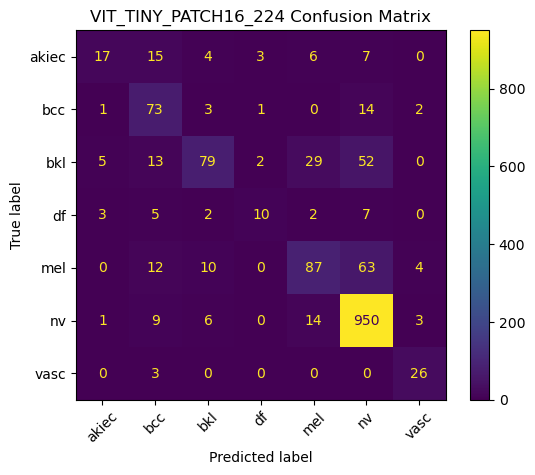


VIT_SMALL_PATCH16_224 Evaluation:
all_labels (unique): [0 1 2 3 4 5 6]
all_preds (unique): [0 1 2 3 4 5 6]
              precision    recall  f1-score   support

       akiec       0.46      0.63      0.53        52
         bcc       0.78      0.68      0.73        94
         bkl       0.80      0.49      0.61       180
          df       0.76      0.45      0.57        29
         mel       0.49      0.76      0.59       176
          nv       0.92      0.90      0.91       983
        vasc       0.92      0.83      0.87        29

    accuracy                           0.80      1543
   macro avg       0.73      0.68      0.69      1543
weighted avg       0.83      0.80      0.81      1543



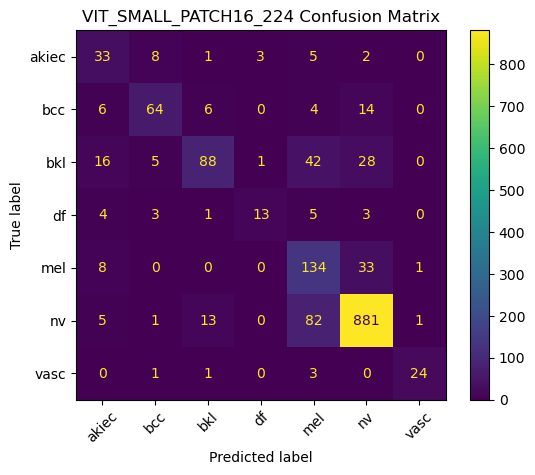


SWIN_TINY_PATCH4_WINDOW7_224 Evaluation:
all_labels (unique): [0 1 2 3 4 5 6]
all_preds (unique): [0 1 2 3 4 5 6]
              precision    recall  f1-score   support

       akiec       0.48      0.79      0.59        52
         bcc       0.70      0.64      0.67        94
         bkl       0.78      0.41      0.54       180
          df       1.00      0.07      0.13        29
         mel       0.46      0.76      0.57       176
          nv       0.92      0.90      0.91       983
        vasc       1.00      0.69      0.82        29

    accuracy                           0.79      1543
   macro avg       0.76      0.61      0.60      1543
weighted avg       0.82      0.79      0.78      1543



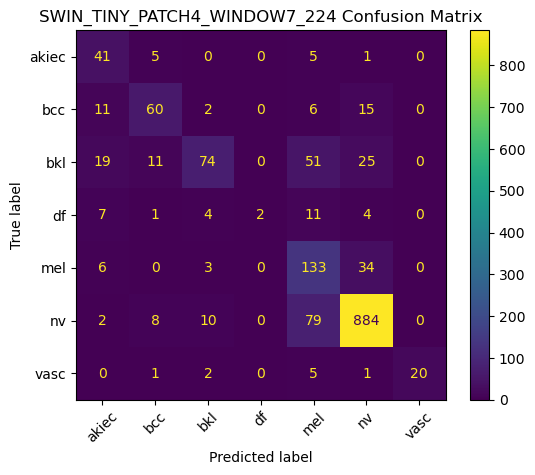

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def evaluate_and_plot(model, test_loader, class_names, model_name=""):
    #set the model to evaluation mode (important for dropout)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():     #no gradients needed for evaluation (faster, less memory)
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Ensure outputs shape 
            if outputs.ndim > 2:
                # Some models output [B, C, 1, 1] or similar, flatten to [B, C]
                outputs = outputs.view(outputs.size(0), outputs.size(1), -1)
                outputs = outputs.mean(-1)
            _, preds = torch.max(outputs, 1)
            # Robust: flatten before adding
            all_preds.extend(np.array(preds.cpu()).flatten().tolist())
            all_labels.extend(np.array(labels.cpu()).flatten().tolist())
    print(f"all_labels (unique): {np.unique(all_labels)}")
    print(f"all_preds (unique): {np.unique(all_preds)}")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation=45)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

#loop for all models
for model_name, model in trained_models.items():
    print(f"\n{model_name.upper()} Evaluation:")
    evaluate_and_plot(model, test_loader, class_names, model_name=model_name.upper())



RESNET18 ROC Curve:


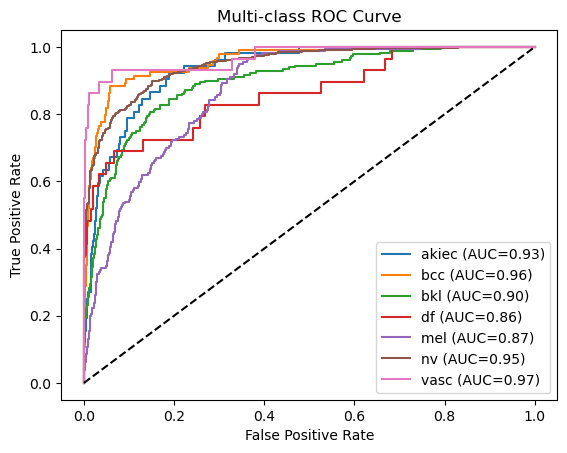


RESNET34 ROC Curve:


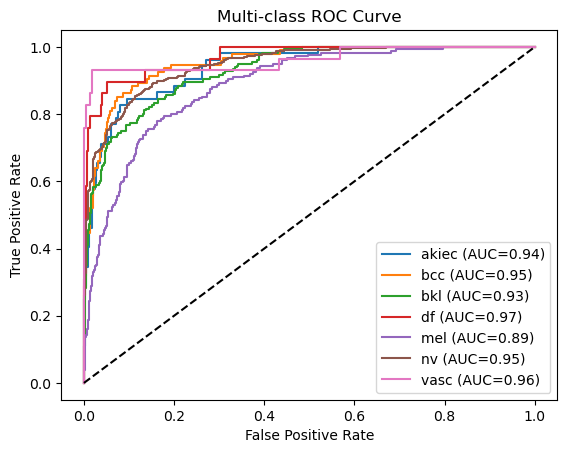


EFFICIENTNET_B0 ROC Curve:


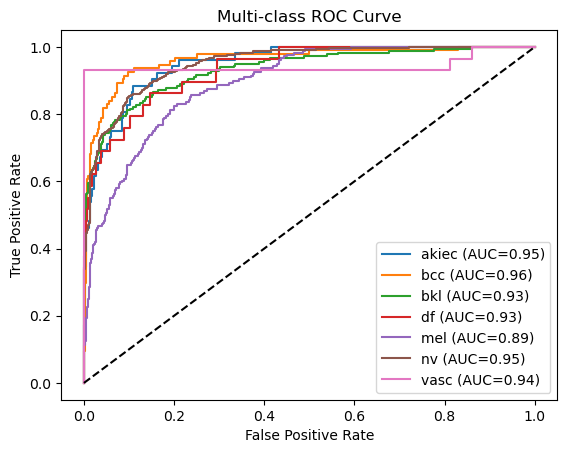


VIT_TINY_PATCH16_224 ROC Curve:


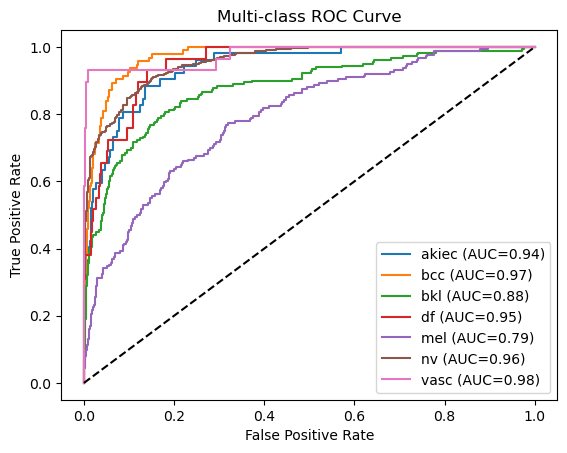


VIT_SMALL_PATCH16_224 ROC Curve:


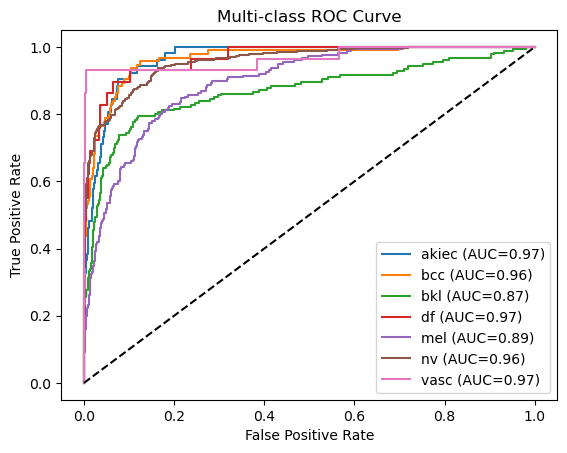


SWIN_TINY_PATCH4_WINDOW7_224 ROC Curve:


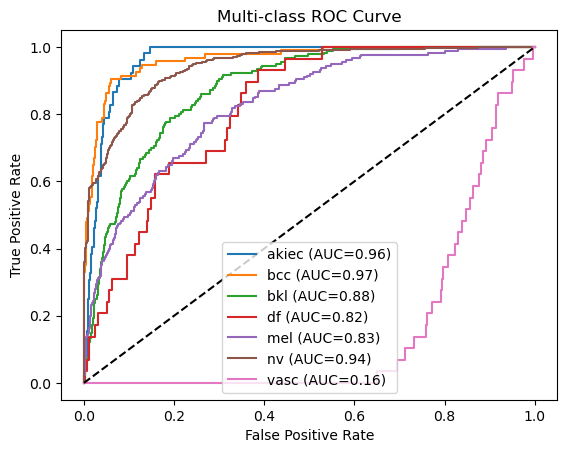

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc(model, test_loader, class_names):
    model.eval()
    y_true = [] #true class indices for all test samples
    y_scores = [] 
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Robustly flatten outputs to [B, C]
            if outputs.ndim > 2:
                outputs = outputs.view(outputs.size(0), outputs.size(1), -1).mean(-1)
            y_scores.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    # convert true labels to one-hot encoding shape [N, C] for ROC curve    
    y_true = label_binarize(y_true, classes=list(range(len(class_names))))
    y_scores = np.array(y_scores)
    #y_true and y_scores should both be [N, C]
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC={roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Multi-class ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Run ROC for all models
for model_name, model in trained_models.items():
    print(f"\n{model_name.upper()} ROC Curve:")
    plot_multiclass_roc(model, test_loader, class_names)


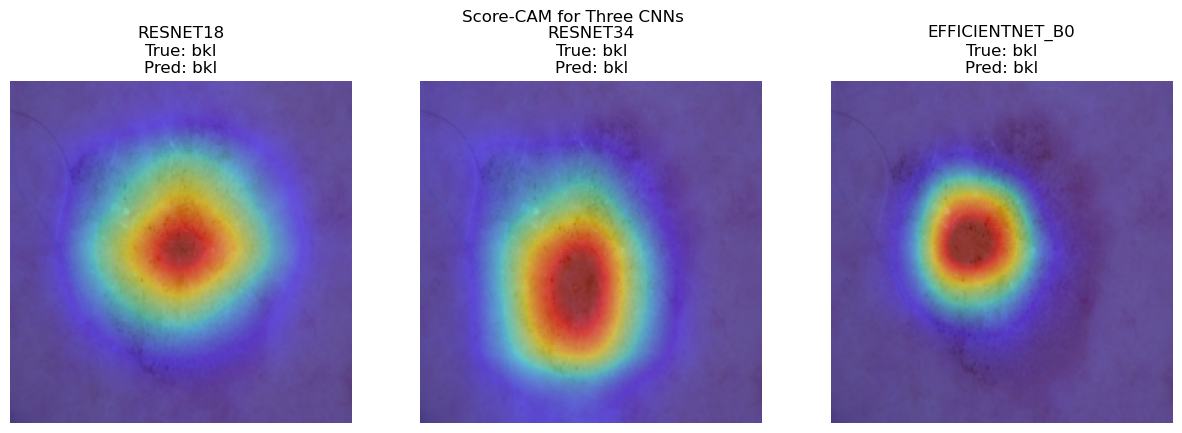

In [15]:
# Score-CAM visualization for all three CNNs (ResNet18, EfficientNet-B0, ResNet34)
from torchcam.methods import ScoreCAM
from torchvision.transforms.functional import to_pil_image
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt

#select a test image 
img_idx = 0
img, label = test_dataset[img_idx]
input_tensor = img.unsqueeze(0).to(device)

# CNN model names in your trained_models dict
cnn_names = ['resnet18','resnet34', 'efficientnet_b0']
# The target layer for each CNN
target_layers = {
    'resnet18': 'layer4',          # last conv block for ResNet18
    'efficientnet_b0': 'blocks.6', # last block for EfficientNet-B0 (timm naming)
    'resnet34': 'layer4',          # last conv block for ResNet34
}

plt.figure(figsize=(5 * len(cnn_names), 5))

for i, cnn_name in enumerate(cnn_names):
    model = trained_models[cnn_name]
    model.eval()  # Set to evaluation mode

    # Create ScoreCAM object for the right layer
    scorecam = ScoreCAM(model, target_layer=target_layers[cnn_name])
    with torch.no_grad():
        output = model(input_tensor) #forward pass
        pred = output.argmax(dim=1).item() #predicted class index
        #get Score-CAM map for predicted class
        cam_map = scorecam(class_idx=pred, scores=output)[0].cpu()
        # Overlay ScoreCAM heatmap on original image
        result = overlay_mask(
            to_pil_image(img * 0.5 + 0.5),  # Unnormalize
            to_pil_image(cam_map, mode='F').resize((224, 224)),
            alpha=0.5 #transparency
        )

    plt.subplot(1, len(cnn_names), i + 1)
    plt.imshow(result)
    plt.title(f"{cnn_name.upper()}\nTrue: {class_names[label]}\nPred: {class_names[pred]}")
    plt.axis('off')

plt.suptitle("Score-CAM for Three CNNs")
plt.show()


Grad-CAM for resnet18


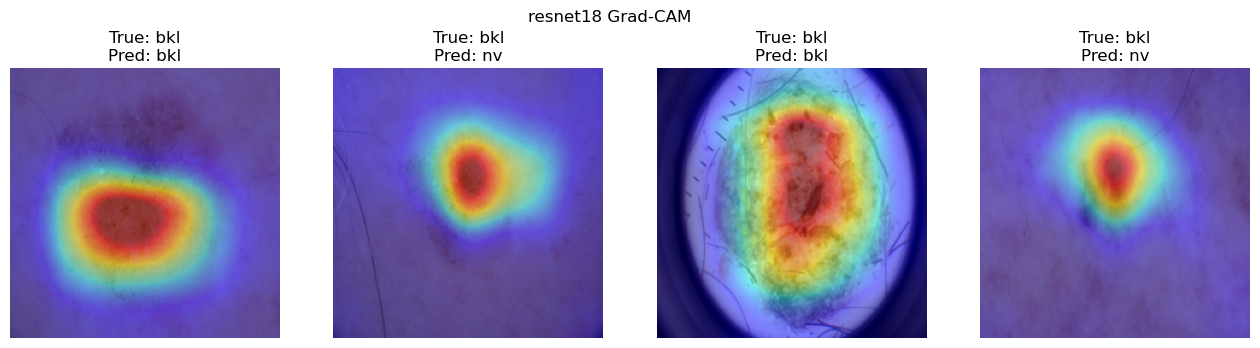

Grad-CAM for resnet34


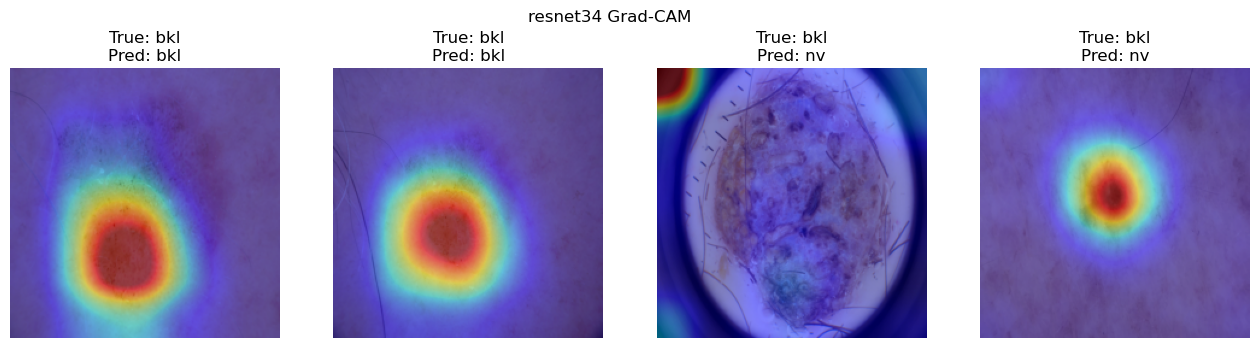

Grad-CAM for efficientnet_b0


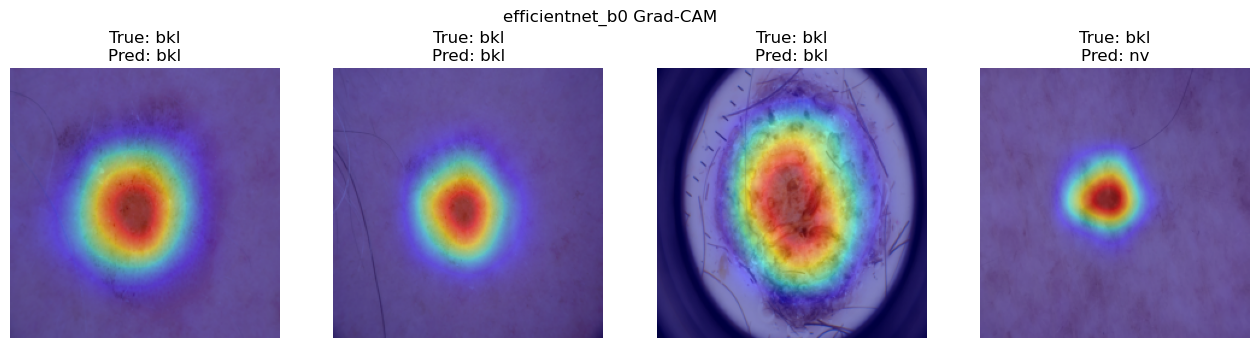

In [16]:
n_images = 4  # no of images to visualize per model
#last convolutional layer for each CNN
target_layers = {
    'resnet18': 'layer4',
    'resnet34': 'layer4',
    'efficientnet_b0': 'blocks.6'
}

for model_name, model in trained_models.items():
    #apply GRAD-CAM on cnns
    if model_configs[model_name]["type"] == "cnn":
        print(f"Grad-CAM for {model_name}")
        last_layer = target_layers[model_name]
         # Create a GradCAM object for this model and layer
        gradcam = GradCAM(model, target_layer=last_layer)
        # Set model to evaluation mode (important for consistency)
        model.eval()
        fig, axs = plt.subplots(1, n_images, figsize=(16, 4))
        for i in range(n_images):
            img, label = test_dataset[i]
            input_tensor = img.unsqueeze(0).to(device)
            out = model(input_tensor) #model prediction (logits)
            pred = out.argmax(dim=1).item() #predicted class index
            # Compute Grad-CAM activation map for predicted class
            act_map = gradcam(class_idx=pred, scores=out)[0].cpu()
            result = overlay_mask(
                to_pil_image(img * 0.5 + 0.5),
                to_pil_image(act_map, mode='F').resize((224, 224)),
                alpha=0.5
            )
            axs[i].imshow(result)
            axs[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}")
            axs[i].axis('off')
        plt.suptitle(f'{model_name} Grad-CAM')
        plt.show()


Attention Rollout for vit_tiny_patch16_224


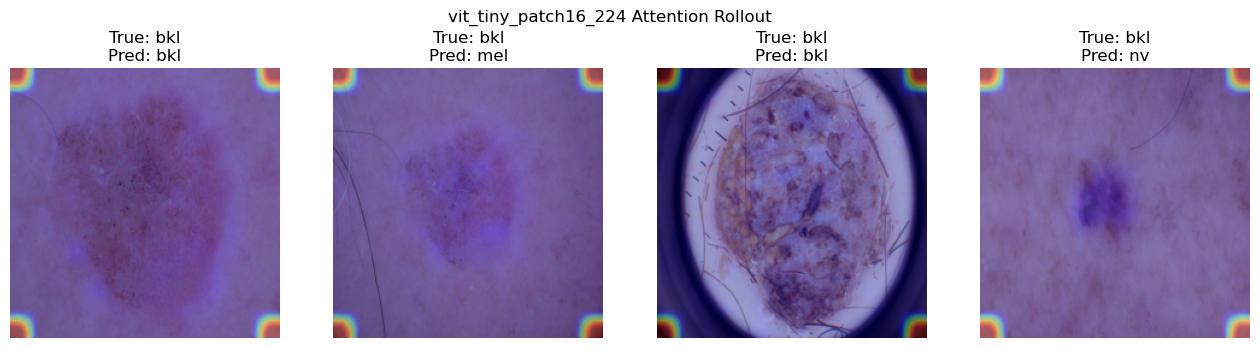

Attention Rollout for vit_small_patch16_224


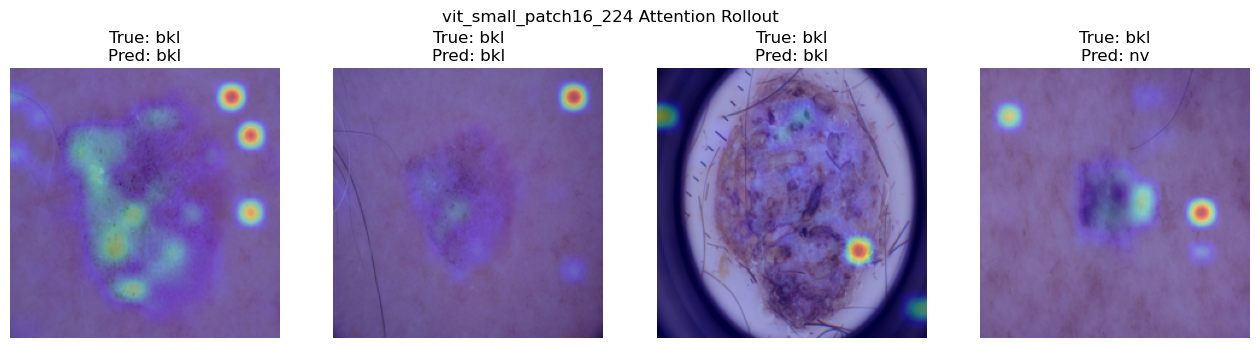

In [17]:
def vit_attention_rollout_timm(model, input_tensor):
    attn_weights = [] #to store weights of each block
    orig_forward = [] #save original forwad method 
    for block in model.blocks:
        orig_forward.append(block.attn.forward)
        def new_forward(self, x):
            B, N, C = x.shape
            qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]
            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            self._saved_attn = attn # Save for later retrieval
            out = (attn @ v).transpose(1, 2).reshape(B, N, C)
            out = self.proj(out)
            return out
        block.attn.forward = new_forward.__get__(block.attn, type(block.attn)) #patch forward
        block.attn.get_attn = lambda self=block.attn: (None, self._saved_attn) #retrieval helper
    #run the model once to collect all attention maps (no grad needed)
    with torch.no_grad():
        _ = model(input_tensor)
    #retrieve collected attention weights and restore original forwards
    for block in model.blocks:
        attn_weights.append(block.attn._saved_attn.cpu())
        block.attn.forward = orig_forward.pop(0)
    #rollout: multiply attention matrices, average over heads, ignore CLS token
    attn_mat = [a.mean(1)[0].numpy() for a in attn_weights]# [layers, N, N]
    rollout = attn_mat[0]
    for a in attn_mat[1:]:
        rollout = rollout @ a
    mask = rollout[0, 1:]
    side = int(mask.shape[0]**0.5)
    attn_map = mask.reshape(side, side)
    return attn_map

n_images = 4 #no of images to visualise
for model_name, model in trained_models.items():
    if model_configs[model_name]["type"] == "vit":
        print(f"Attention Rollout for {model_name}")
        model.eval()
        fig, axs = plt.subplots(1, n_images, figsize=(16, 4))
        for i in range(n_images):
            img, label = test_dataset[i]
            input_tensor = img.unsqueeze(0).to(device)
            #model predition
            out = model(input_tensor)
            pred = out.argmax(dim=1).item()
            #get attention map(rollout)
            attn_map = vit_attention_rollout_timm(model, input_tensor)
            attn_map_resized = np.array(Image.fromarray((attn_map/attn_map.max()*255).astype(np.uint8)).resize((224, 224)))
            axs[i].imshow(img.permute(1,2,0).numpy()*0.5+0.5) #unnormalize for display
            axs[i].imshow(attn_map_resized, cmap='jet', alpha=0.4)
            axs[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}")
            axs[i].axis('off')
        plt.suptitle(f'{model_name} Attention Rollout')
        plt.show()


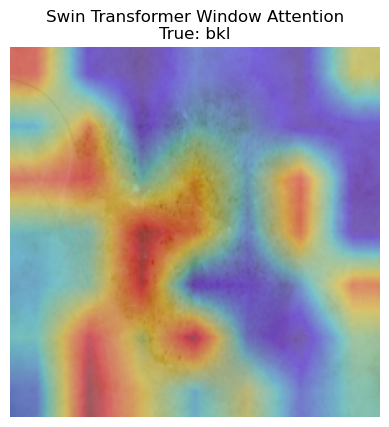

In [18]:
def swin_window_attention_map(model, input_tensor):
    import numpy as np
    from PIL import Image

    # Get last block of last stage
    last_stage = model.layers[-1]
    last_block = last_stage.blocks[-1]
    attn_maps = []
    #hook to capture attention output from the last block
    def hook_fn(module, input, output):
        # output: [num_windows*B, num_heads, ws*ws, ws*ws]
        # We average over heads (usually dim 1)
        if output.ndim == 4:
            attn = output.mean(1)  # shape: [num_windows*B, ws*ws, ws*ws]
        elif output.ndim == 3:
            attn = output  # fallback, rare
        else:
            raise ValueError(f"Unexpected output shape: {output.shape}")
        attn_maps.append(attn.detach().cpu())

    handle = last_block.attn.register_forward_hook(hook_fn)
    #forward pass to trigger the hook and capture attention
    with torch.no_grad():
        _ = model(input_tensor)
    handle.remove() #clean

    if len(attn_maps) == 0:
        print("Attention map not captured")
        return None

    attn = attn_maps[0]  # shape: [num_windows*B, ws*ws, ws*ws]
    # Average across windows if >1
    attn = attn.mean(0)  # shape: [ws*ws, ws*ws] 

    if attn.ndim == 2:
        # Take diagonal: focus on each pixel's self-attention
        avg_diag = attn.diagonal()
    elif attn.ndim == 1:
        avg_diag = attn  # fallback: already 1D
    else:
        raise ValueError(f"Unexpected attn ndim: {attn.ndim}")

    wsq = avg_diag.shape[0]
    window_side = int(np.sqrt(wsq))
    if window_side * window_side != wsq:
        # If not perfect square, try to reshape safely (or warn)
        print(f"Warning: attention vector is not square ({wsq}), reshaping to best fit.")
        window_side = int(np.round(np.sqrt(wsq)))
        avg_diag = avg_diag[:window_side * window_side]
    avg_diag = avg_diag.reshape(window_side, window_side).numpy()

    attn_img = Image.fromarray((avg_diag / avg_diag.max() * 255).astype(np.uint8))
    attn_img = attn_img.resize((224, 224), resample=Image.BILINEAR)
    return np.array(attn_img)
swin_model = trained_models['swin_tiny_patch4_window7_224']
img, label = test_dataset[0]
input_tensor = img.unsqueeze(0).to(device)
attn_map = swin_window_attention_map(swin_model, input_tensor)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
if attn_map is not None:
    plt.imshow(attn_map, cmap='jet', alpha=0.4)
plt.title(f"Swin Transformer Window Attention\nTrue: {class_names[label]}")
plt.axis('off')
plt.show()


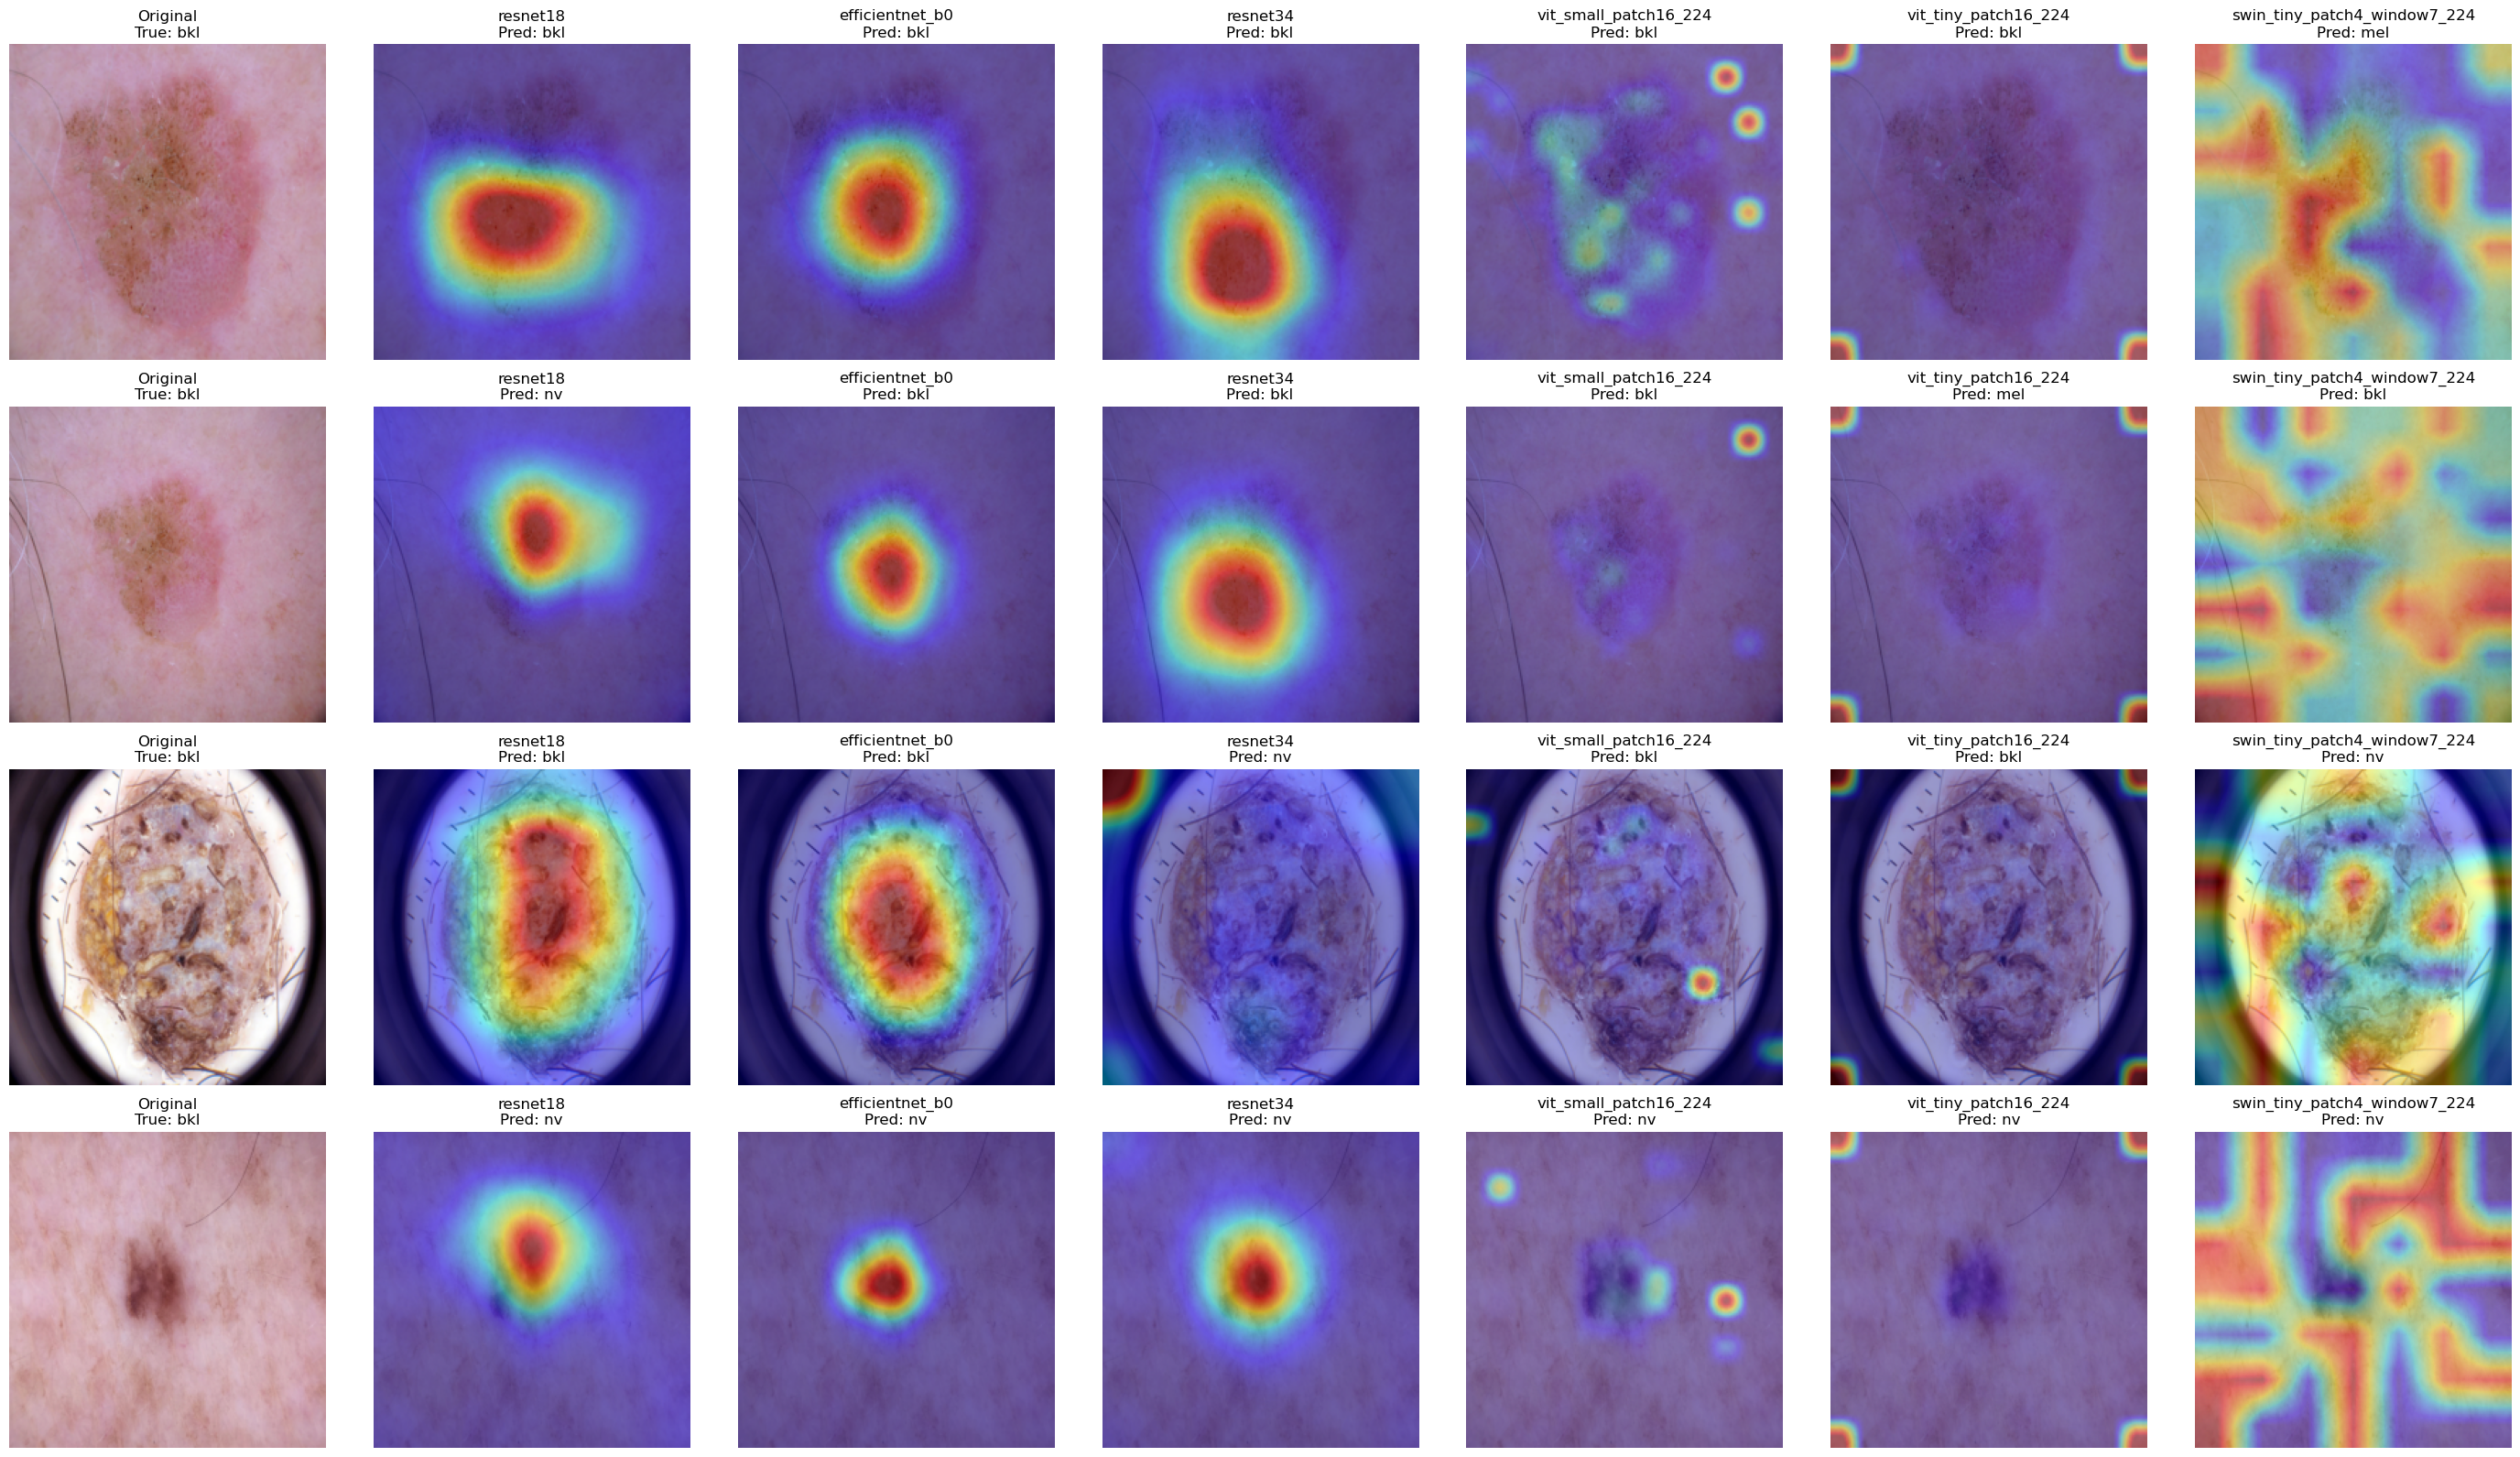

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# List of models to visualize
model_list = [
    "resnet18", "efficientnet_b0", "resnet34",
    "vit_small_patch16_224", "vit_tiny_patch16_224", "swin_tiny_patch4_window7_224"
]
n_images = 4  # Number of test images to show
n_models = len(model_list)
# Map each model name to the XAI method that should be used for it
model_xai = {
    "resnet18": "gradcam",
    "efficientnet_b0": "gradcam",
    "resnet34": "gradcam",
    "vit_small_patch16_224": "attn_rollout",
    "vit_tiny_patch16_224": "attn_rollout",
    "swin_tiny_patch4_window7_224": "swin_attn"
}

fig, axs = plt.subplots(n_images, n_models + 1, figsize=(4 * (n_models + 1), 4 * n_images))

for i in range(n_images):
    img, label = test_dataset[i] #get image and label from dataset
    orig = img.permute(1, 2, 0).numpy() * 0.5 + 0.5
    axs[i, 0].imshow(orig)
    axs[i, 0].set_title(f"Original\nTrue: {class_names[label]}")
    axs[i, 0].axis('off')
    for j, model_name in enumerate(model_list):
        model = trained_models[model_name]
        xai_type = model_xai[model_name] #type of xai model
        input_tensor = img.unsqueeze(0).to(device) #batch preparation

        # CNN GradCAM
        if xai_type == "gradcam": 
            #choose last convolutional layer for GradCAM
            if model_name.startswith('resnet'):
                target_layer = "layer4"
            elif model_name.startswith('efficientnet'):
                target_layer = "blocks.6"
            else:
                target_layer = None
            gradcam = GradCAM(model, target_layer=target_layer)
            model.eval()
            out = model(input_tensor)
            if out.ndim > 2:
                out = out.view(out.size(0), out.size(1), -1).mean(-1)
            pred = out.argmax(dim=1).item()
            act_map = gradcam(class_idx=pred, scores=out)[0].cpu()
            overlay = overlay_mask(
                to_pil_image(img * 0.5 + 0.5),
                to_pil_image(act_map, mode='F').resize((224, 224)),
                alpha=0.5
            )
            axs[i, j + 1].imshow(overlay)
            axs[i, j + 1].set_title(f"{model_name}\nPred: {class_names[pred]}")
            axs[i, j + 1].axis('off')
            del gradcam

        # ViT Attention Rollout
        elif xai_type == "attn_rollout":
            model.eval()
            out = model(input_tensor)
            if out.ndim > 2:
                out = out.view(out.size(0), out.size(1), -1).mean(-1)
            pred = out.argmax(dim=1).item()
            attn_map = vit_attention_rollout_timm(model, input_tensor)  # <-- Use your working function
            attn_map_resized = np.array(
                Image.fromarray((attn_map / attn_map.max() * 255).astype(np.uint8)).resize((224, 224))
            )
            axs[i, j + 1].imshow(orig)
            axs[i, j + 1].imshow(attn_map_resized, cmap='jet', alpha=0.4)
            axs[i, j + 1].set_title(f"{model_name}\nPred: {class_names[pred]}")
            axs[i, j + 1].axis('off')

        # Swin Attention
        elif xai_type == "swin_attn":
            model.eval()
            out = model(input_tensor)
            if out.ndim > 2:
                out = out.view(out.size(0), out.size(1), -1).mean(-1)
            pred = out.argmax(dim=1).item()
            attn_map = swin_window_attention_map(model, input_tensor)
            axs[i, j + 1].imshow(orig)
            if attn_map is not None:
                axs[i, j + 1].imshow(attn_map, cmap='jet', alpha=0.4)
            axs[i, j + 1].set_title(f"{model_name}\nPred: {class_names[pred]}")
            axs[i, j + 1].axis('off')

plt.tight_layout()
plt.show()
